One of my favourite charts is the 100% stacked bar chart. Think of a a Pie chart, but one that better shows the split of data and that you can easily show over time or with multiple categories without an issue.

It’s best used when you don’t need to see the total movement, but instead the change in distribution such as between competing companies in a market, or relative sales revenues brought in by different people.

I’d been doing these in Excel for a while but hadn’t tackled it in Python. There was a few resources I found but ended up writing most of this myself. You can see the full code and datasets in my [GitHub repo](https://github.com/ryanward-io/charting).

Let’s use the [World Bank data set of GDP by country since 1960](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD). What we want to see is how the distribution of global GDP by continent has changed over time. I also use a data set I found ~~published online~~ _and it's a dead link now_ that acts as a lookup table of country to continent. These are both accessed from my GitHub as I don’t know if they disappear or change over time.

As with all things data, we start with transforming the data into a useful form. Below is the code that imports all libraries and datasets, cleans the GDP DataFrame, and merges the lookup data into the GDP DataFrame.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

gdp_world_bank_csv = "https://raw.githubusercontent.com/ryanward-io/charting/master/data/world_bank_GDP.csv"
lookup_csv = "https://raw.githubusercontent.com/ryanward-io/charting/master/data/continent_to_country_lookup.csv"

gdp_df = pd.read_csv(gdp_world_bank_csv)
lookup_df = pd.read_csv(lookup_csv)

# Removing unnecessary columns and renaming columns for consistency
gdp_df = gdp_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])\
               .rename(columns={"Country Name": "Country_Name"})

# Merging the lookup table into the GDP dataset.
gdp_df = pd.merge(gdp_df, lookup_df, on="Country_Name")

#We are just looking at continents, otherwise it would be too busy.
gdp_df.drop(['Country_Name'], axis=1, inplace=True)

gdp_df = gdp_df.groupby('Continent_Name').sum().T
gdp_df.tail()

Continent_Name,Africa,Asia,Europe,North America,Oceania,South America
2015,2.331355e+12,2.743490e+13,2.029734e+13,2.152319e+13,1.567079e+12,3.353879e+12
2016,2.186643e+12,2.840264e+13,2.022827e+13,2.191001e+13,1.434843e+12,3.307646e+12
2017,2.212164e+12,3.068479e+13,2.145087e+13,2.291493e+13,1.576361e+12,3.752571e+12
2018,2.330966e+12,3.260469e+13,2.296101e+13,2.415106e+13,1.683492e+12,3.514392e+12
2019,2.420123e+12,3.340433e+13,2.258863e+13,2.496280e+13,1.633667e+12,3.373180e+12


Next we transform the absolute values into a proportional value out of 100%.

This is done by dividing each item in each DataFrame row by the sum of each row. The end result is each row now adds to 1.

In [7]:
gdp_100_df = gdp_df.div(gdp_df.sum(axis=1), axis=0)
gdp_100_df.tail()

Continent_Name,Africa,Asia,Europe,North America,Oceania,South America
2015,0.030472,0.358590,0.265298,0.281320,0.020483,0.043837
2016,0.028226,0.366627,0.261111,0.282819,0.018521,0.042696
2017,0.026784,0.371524,0.259722,0.277448,0.019086,0.045435
2018,0.026717,0.373712,0.263177,0.276817,0.019296,0.040282
2019,0.027382,0.377951,0.255577,0.282440,0.018484,0.038166


We are now ready to make the charts.

For a 100% stacked bar chart the special element to add to a bar chart is the ‘bottom’ parameter when plotting the data. This defines the bottom of each data point – we’ll be specifying this so the bottom of each continent bar is the top of the prior continent. By the end, this should have added to 1 so that each total bar is the same height.

In [9]:
bottom_list = []

# Loops through each continent column. 
# Each column will take the sum of all columns before it as its base.

for i in gdp_100_df.columns:
    b = list(gdp_100_df.loc[:, gdp_df.columns[0]: i].sum(axis=1))
    bottom_list.append(b)

Now we have our ‘bottoms’, we can plot the chart.

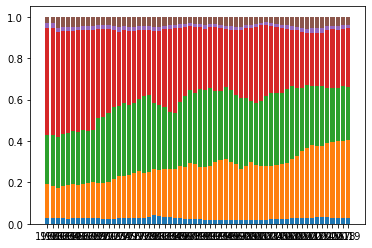

In [28]:
fig, ax = plt.subplots()

x_ax = gdp_100_df.index

def plot_stacked_bar_chart():
    for i, v in enumerate(gdp_100_df.columns):
        if i == 0:
            # First column is at the bottom of the chart
            # so bottom is 0 and doesn't need to be specified.
            plt.bar(x_ax, gdp_100_df[v])
        else:
            plt.bar(x_ax, gdp_100_df[v], bottom=bottom_list[i - 1])

plot_stacked_bar_chart()
plt.show()

The bars have worked, with each stack determining their bottom from the top of the prior stack. However, the axes is a hot mess and there are a few formatting things we can easily clean up. We do that quickly below.

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

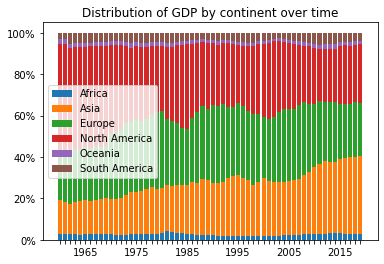

In [48]:
fig, ax = plt.subplots()

# y-axis formatting
plot_stacked_bar_chart()
y_vals = ax.get_yticks()[:6]
ax.set_yticks(y_vals)
ax.set_yticklabels([f'{y:.0%}' for y in y_vals])

# # x-axis formatting
n = 10  # Keeps every nth label
[l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 5]

# Other formatting
plt.legend(labels=gdp_100_df.columns)
plt.title('Distribution of GDP by continent over time')

plt.show()

Much better!

Despite spikes in GDP proportion around 1985 and 2000 (both times of high growth, just before major crashes of [Black Monday [1987]](https://en.wikipedia.org/wiki/Black_Monday_(1987)) and the [Dot-Com Bubble [2000]](https://en.wikipedia.org/wiki/Dot-com_bubble)), the trend shows North America losing about 25% share of global GDP since 1960, almost entirely to an increase in Asia.

Hope this helps present information from a different angle – you’d be surprised where this can come in useful.